In [ ]:
# Needed: 
# uv pip install trimesh
# uv pip install cartopy

In [ ]:
from anemoi.graphs.generate.tri_icosahedron import get_latlon_coords_icosphere, create_nx_graph_from_tri_coords, create_node_neighbours_list, get_neighbours_within_hops
from anemoi.graphs.generate.utils import get_coordinates_ordering
import matplotlib.pyplot as plt
import cartopy
import networkx as nx
from sklearn.neighbors import BallTree
import numpy as np
import trimesh
from anemoi.graphs.generate.transforms import cartesian_to_latlon_rad
from anemoi.graphs.generate.masks import KNNAreaMaskBuilder

In [227]:
resol = 3

In [252]:
lat_min, lat_max = -20, 20   # degrees
lon_min, lon_max = -20, 20 # degrees


In [253]:
icosphere_glob = get_latlon_coords_icosphere(resolution=resol)
node_ordering = get_coordinates_ordering(icosphere_glob)

In [254]:
lats = np.degrees(icosphere_glob[:,0])
lons = np.degrees(icosphere_glob[:,1])

mask = (lats >= lat_min) & (lats <= lat_max) & \
       (lons >= lon_min) & (lons <= lon_max)
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False,

In [ ]:
graph = create_nx_graph_from_tri_coords(coords_rad=icosphere_glob, node_ordering=node_ordering)

In [ ]:
# This function is taken from Anemoi.graphs.src.anemoi.graphs.generate
# KNNAreaMaskBuilder is not used. 

def add_edges_to_nx_graph(
    graph: nx.DiGraph,
    resolutions: list[int],
    x_hops: int = 1,
    area_mask_builder = None,
) -> nx.DiGraph:

    assert x_hops > 0, "x_hops == 0, graph would have no edges ..."

    graph_vertices = np.array([graph.nodes[i]["hcoords_rad"] for i in sorted(graph.nodes)])
    tree = BallTree(graph_vertices, metric="haversine")

    # Build the multi-scale connections
    for resolution in resolutions:
        # Define the coordinates of the isophere vertices at specified 'resolution' level
        r_sphere = trimesh.creation.icosphere(subdivisions=resolution, radius=1.0)
        r_vertices_rad = cartesian_to_latlon_rad(r_sphere.vertices)

        # Limit area of mesh points.
        if area_mask_builder is not None:
            area_mask = area_mask_builder.get_mask(r_vertices_rad)
            valid_nodes = np.where(area_mask)[0]
        else:
            valid_nodes = None

        node_neighbours = get_neighbours_within_hops(r_sphere, x_hops, valid_nodes=valid_nodes)

        _, vertex_mapping_index = tree.query(r_vertices_rad, k=1)
        neighbour_pairs = create_node_neighbours_list(graph, node_neighbours, vertex_mapping_index)
        graph.add_edges_from(neighbour_pairs)
    return graph


In [258]:
graph = add_edges_to_nx_graph(graph=graph, resolutions=list(range(1, resol+2)))

In [278]:
nodes_window = np.arange(len(icosphere_glob))[~mask]
old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(nodes_window)}

In [288]:
edges = np.array(graph.edges)
mask_edges = np.isin(edges[:,0], nodes_window) & np.isin(edges[:,1], nodes_window)
edges_window = edges[mask_edges]
edges = np.array([[old_to_new[u], old_to_new[v]] for u, v in edges_window])

In [289]:
x = icosphere_glob[~mask]

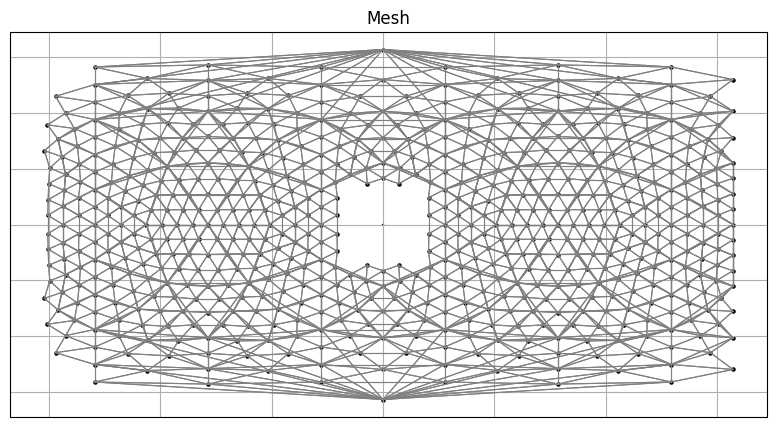

In [290]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

lats = x[:,0]
lons = x[:,1]

plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

# --- draw nodes ---
ax.scatter(lons, lats, s=5, color='black',
           transform=ccrs.PlateCarree())

plt.title("Mesh")


#--- draw edges ---
for i, j in edges:
    lat_pair = [lats[i], lats[j]]
    lon_pair = [lons[i], lons[j]]
    
    lon_pair_deg = np.degrees(lon_pair)
    if np.abs(lon_pair_deg[1] - lon_pair_deg[0]) > 180:
        # skip this edge
        continue
    ax.plot(lon_pair, lat_pair,
            linewidth=0.8,
            color='gray',
            transform=ccrs.PlateCarree())


plt.grid(True)
plt.show()

In [ ]:
import numpy as np


# 3D Cartesian coordinates for all nodes from the 2d latlon
cartesian_pos = {}
for n, data in enumerate(x):
    lat, lon = data 
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    cartesian_pos[n] = (x, y, z)


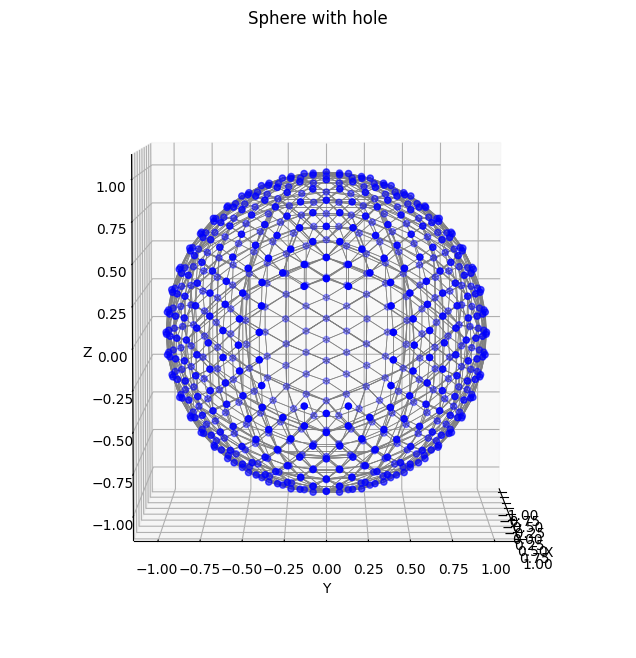

In [308]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# draw edges
for u, v in edges:
    x_pair = [cartesian_pos[u][0], cartesian_pos[v][0]]
    y_pair = [cartesian_pos[u][1], cartesian_pos[v][1]]
    z_pair = [cartesian_pos[u][2], cartesian_pos[v][2]]
    ax.plot(x_pair, y_pair, z_pair, color='gray', alpha=0.9, linewidth=0.5)

# draw nodes
x_nodes = [c[0] for c in cartesian_pos.values()]
y_nodes = [c[1] for c in cartesian_pos.values()]
z_nodes = [c[2] for c in cartesian_pos.values()]
ax.scatter(x_nodes, y_nodes, z_nodes, color='blue', s=20)


ax.set_box_aspect([1,1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Sphere with hole")
elev = 5 
azim = 0
ax.view_init(elev=elev, azim=azim)
plt.show()
